In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [54]:
df = pd.read_csv('data2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [55]:
lb = LabelEncoder()

df['Class'] = lb.fit_transform(df['Class'])
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,1
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,1
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,1
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,1
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,1


In [56]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,1
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,1
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,1
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,1
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,1


In [57]:
df['Class'].value_counts()

1    450
0    450
Name: Class, dtype: int64

In [58]:
df.isna().sum().sum()

0

In [59]:
df.duplicated().sum()

0

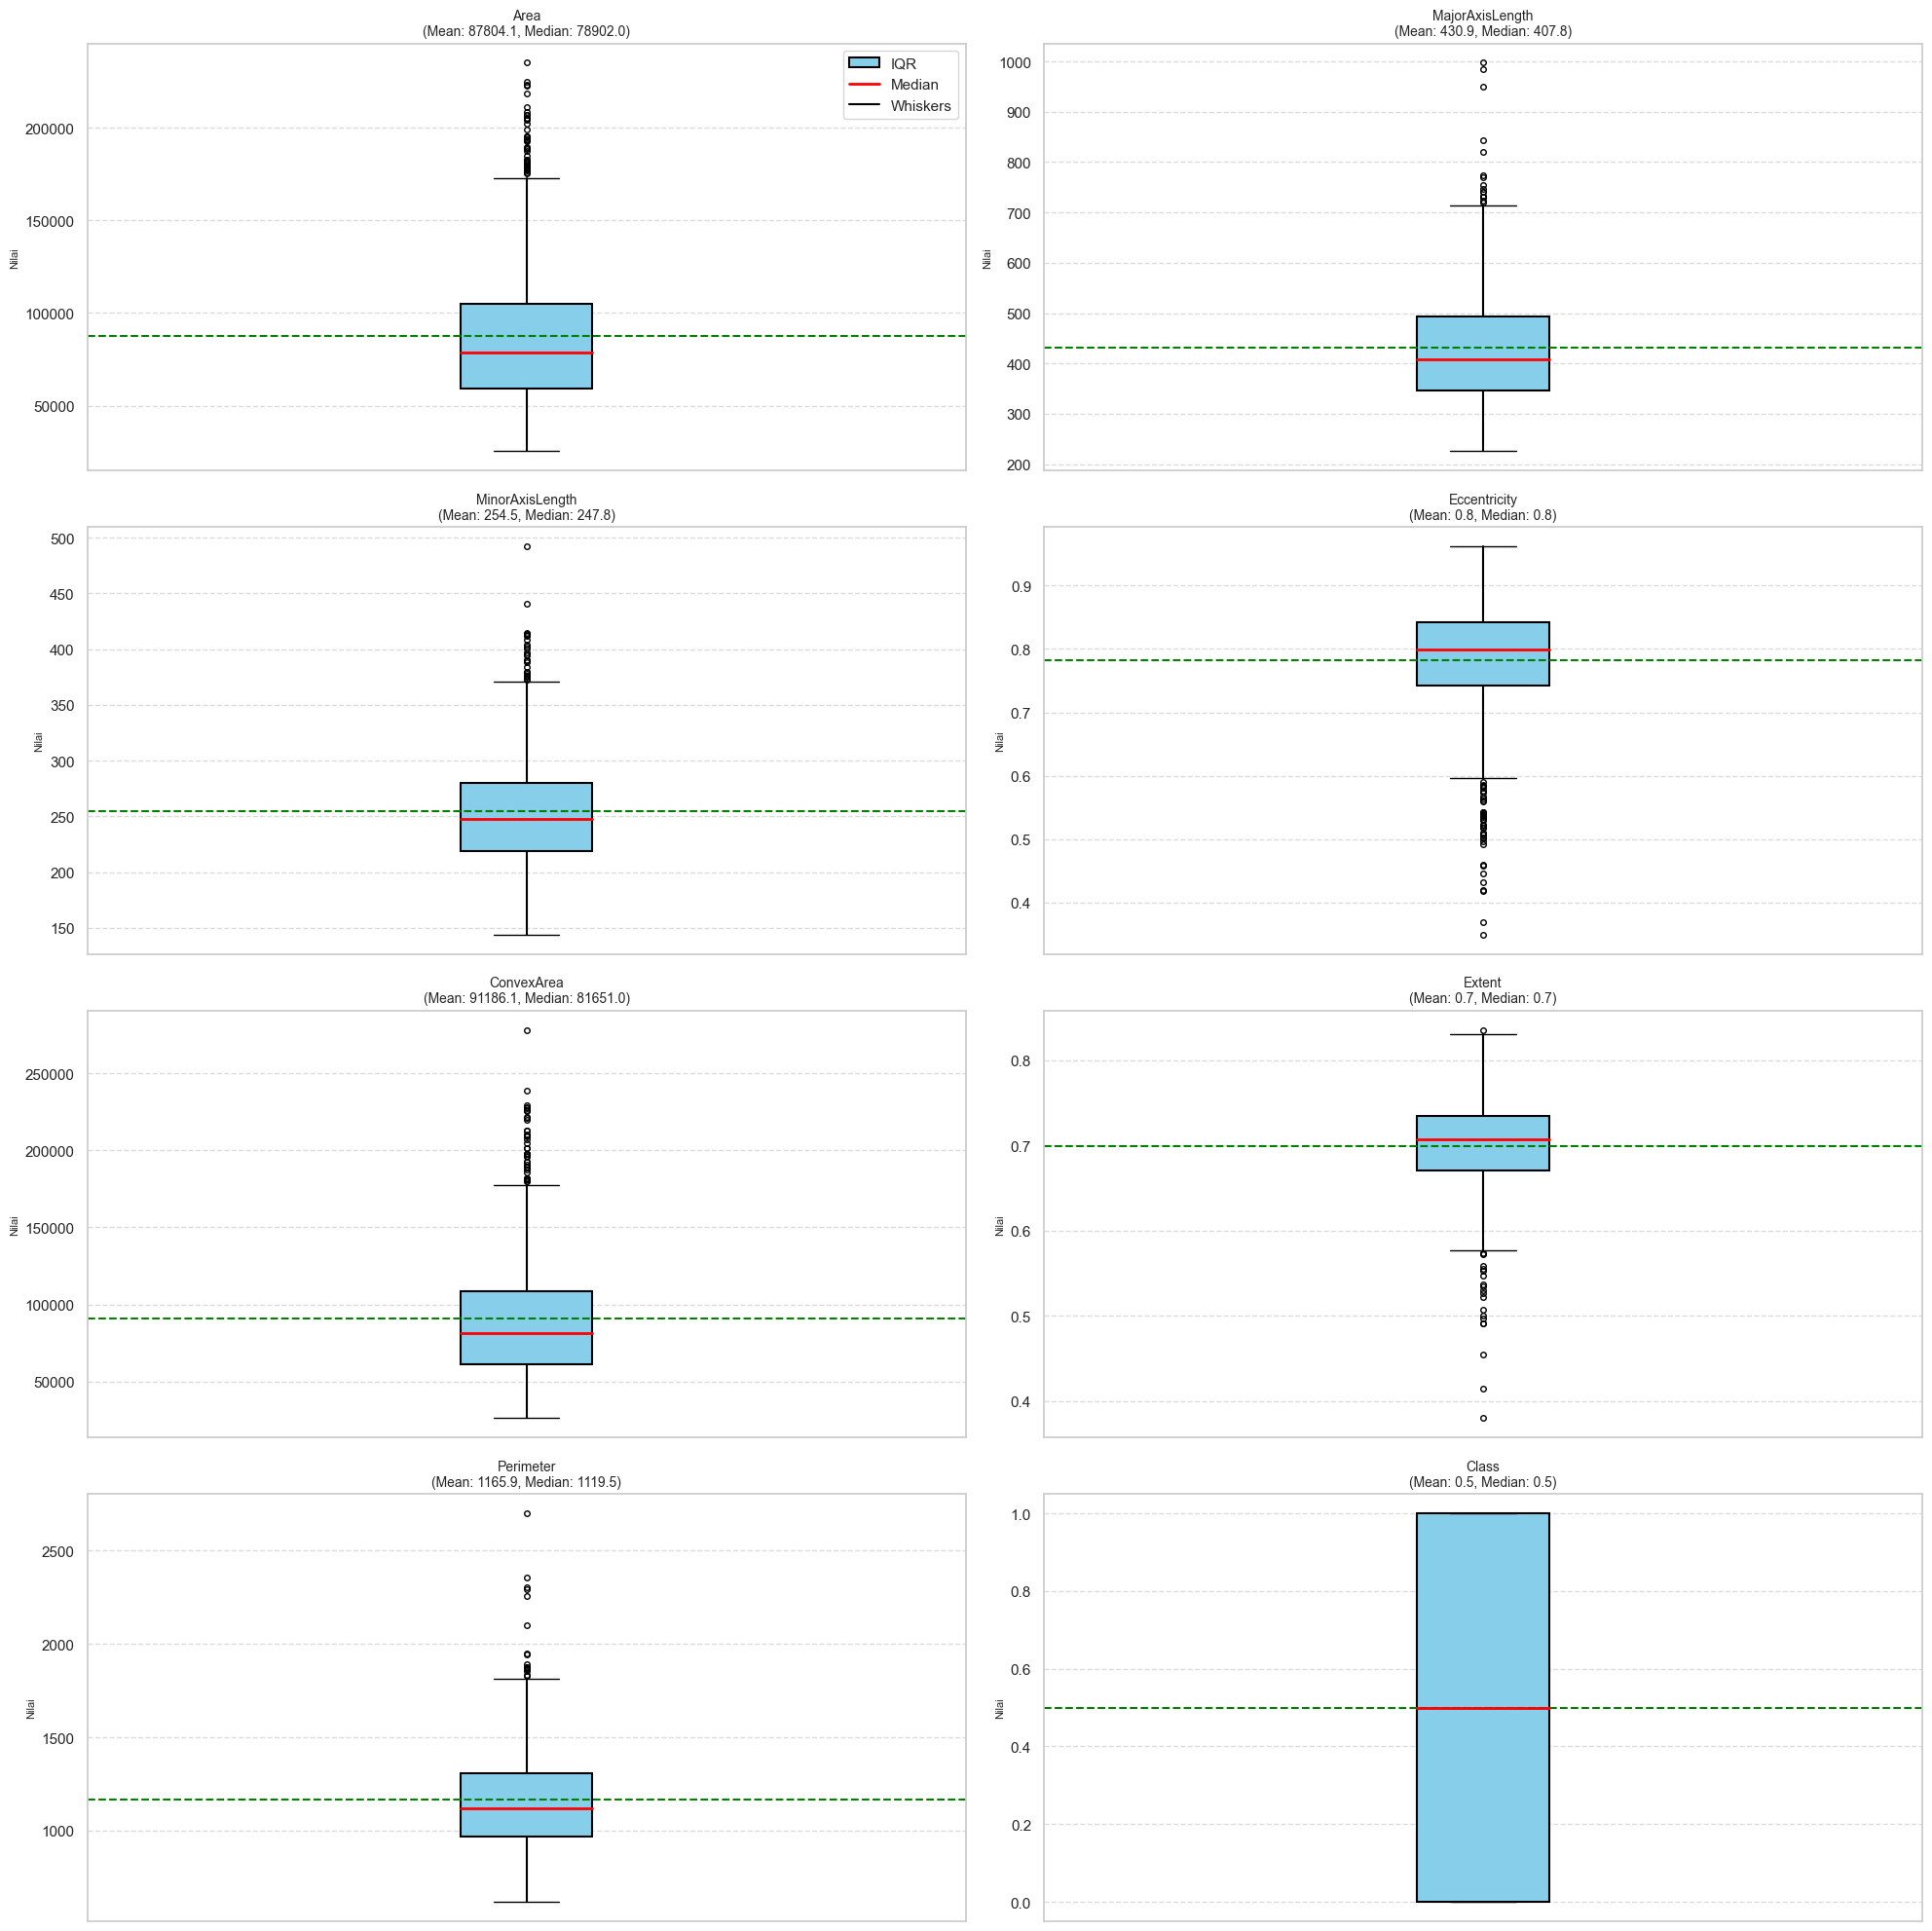

In [60]:
sns.set_theme(style='whitegrid')
numerical_cols = df.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

boxprops = dict(facecolor='skyblue', linewidth=1.5)
whiskerprops = dict(color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df[col].dropna()
    
    bp = axis.boxplot(data,
                      vert=True,
                      patch_artist=True,
                      boxprops=boxprops,
                      whiskerprops=whiskerprops,
                      medianprops=medianprops,
                      flierprops=dict(marker='o', markersize=4))
    
    mean_val = data.mean()
    axis.axhline(mean_val, color='green', linestyle='--', linewidth=1.5)
    
    axis.set_title(f'{col}\n(Mean: {mean_val:.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_ylabel('Nilai', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    axis.set_xticks([])
    
    if i == 0:  
        axis.legend([bp['boxes'][0], bp['medians'][0], bp['whiskers'][0]], 
                   ['IQR', 'Median', 'Whiskers'],
                   loc='upper right')

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

In [61]:
df2 = df.copy()

In [62]:
def outlier_remover(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.3*IQR
    upper_bound = Q3 + 1.3*IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [63]:
num_col = df2.select_dtypes(include='number').columns
for i in num_col.tolist():
    df2 = outlier_remover(df2, i)

print(f"Sebelum penghapusan outlier {df.shape} setelah {df2.shape}")

Sebelum penghapusan outlier (900, 8) setelah (736, 8)


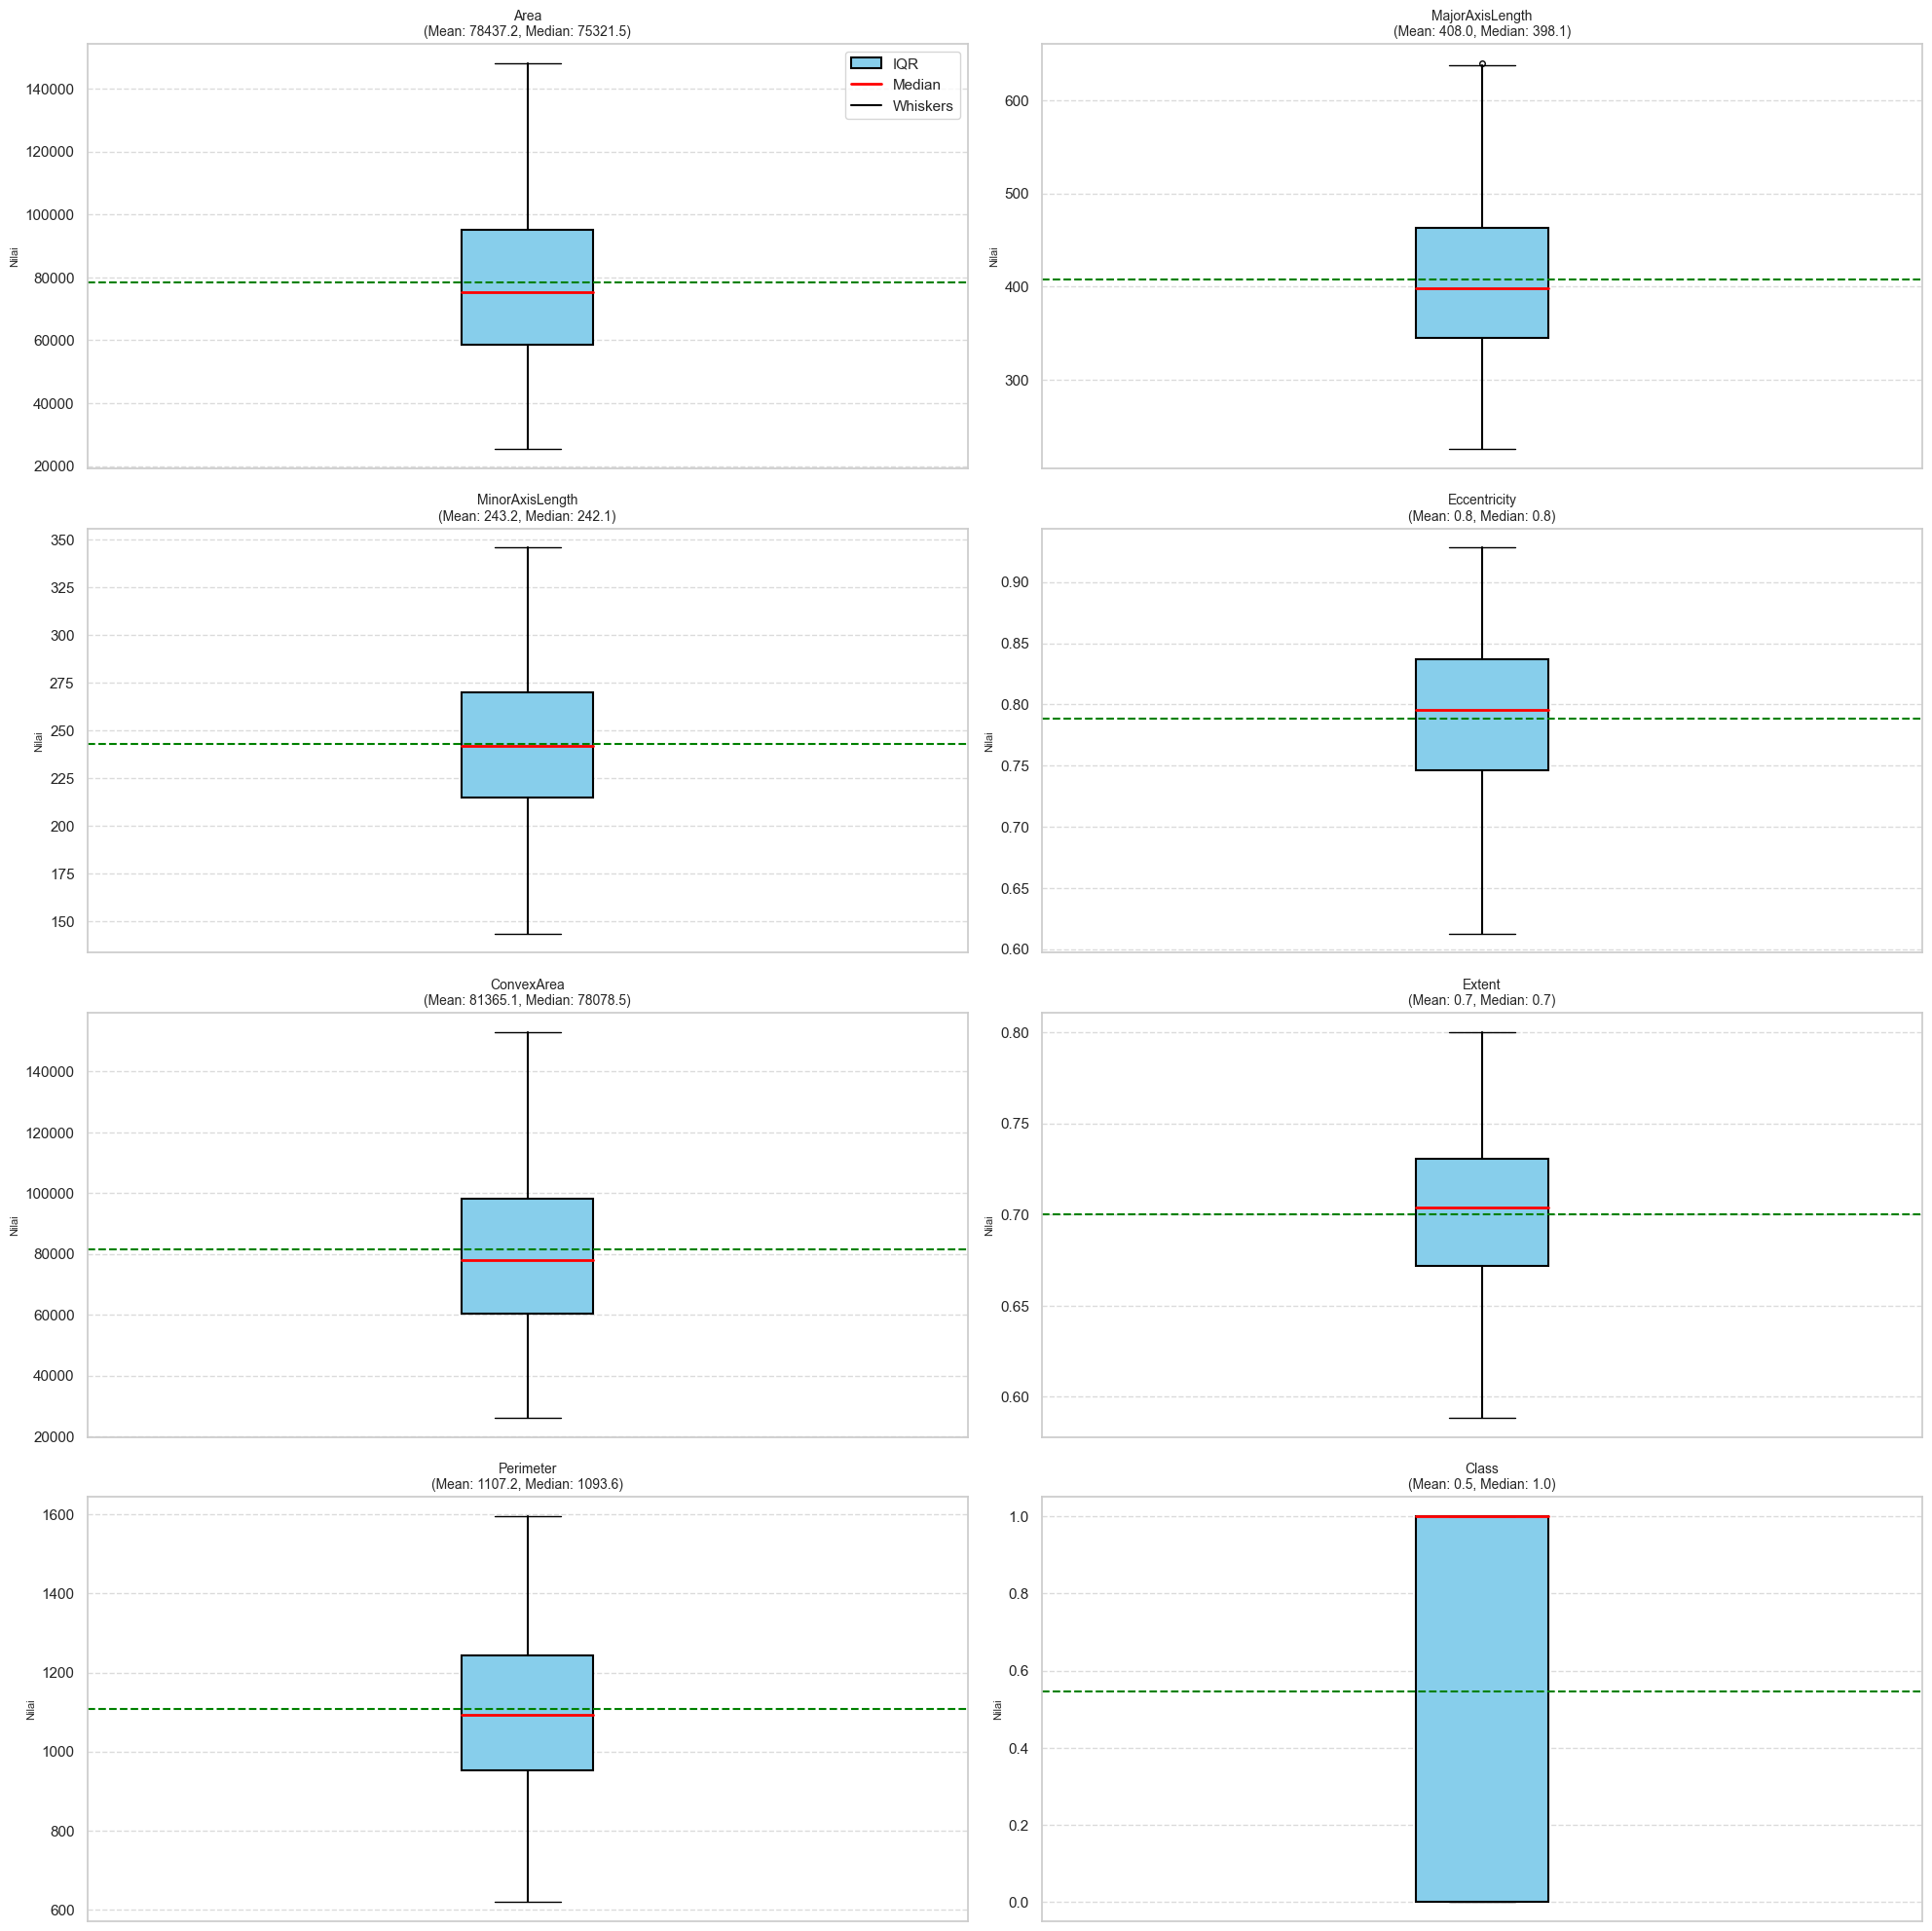

In [64]:
sns.set_theme(style='whitegrid')
numerical_cols = df2.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

boxprops = dict(facecolor='skyblue', linewidth=1.5)
whiskerprops = dict(color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df2[col].dropna()
    
    bp = axis.boxplot(data,
                      vert=True,
                      patch_artist=True,
                      boxprops=boxprops,
                      whiskerprops=whiskerprops,
                      medianprops=medianprops,
                      flierprops=dict(marker='o', markersize=4))
    
    mean_val = data.mean()
    axis.axhline(mean_val, color='green', linestyle='--', linewidth=1.5)
    
    axis.set_title(f'{col}\n(Mean: {mean_val:.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_ylabel('Nilai', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    axis.set_xticks([])
    
    if i == 0:  
        axis.legend([bp['boxes'][0], bp['medians'][0], bp['whiskers'][0]], 
                   ['IQR', 'Median', 'Whiskers'],
                   loc='upper right')

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

In [65]:
df['Class'].value_counts()

1    450
0    450
Name: Class, dtype: int64

In [66]:
x1 = df.drop(columns='Class')
y1 = df['Class']

x2 = df2.drop(columns='Class')
y2 = df2['Class']

In [67]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1,y1,test_size=0.2,random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2,y2,test_size=0.2,random_state=42)

In [68]:
ct = CatBoostClassifier(random_state=42, verbose=0)
ct.fit(x_train1,y_train1)
y_pred_ct1 = ct.predict(x_test1)

ct2 = CatBoostClassifier(random_state=42, verbose=0)
ct2.fit(x_train2,y_train2)
y_pred_ct2 = ct2.predict(x_test2)

akurasi_cb1 = accuracy_score(y_test1, y_pred_ct1)
f1_cb1 = f1_score(y_test1, y_pred_ct1)
akurasi_cb2 = accuracy_score(y_test2, y_pred_ct2)
f1_cb2 = f1_score(y_test2, y_pred_ct2)

In [69]:
print(f"hasil D1 Akuarasi: {akurasi_cb1}    f1: {f1_cb1}")
print(f"hasil D2 Akuarasi: {akurasi_cb2}    f1: {f1_cb2}")

hasil D1 Akuarasi: 0.8666666666666667    f1: 0.8736842105263158
hasil D2 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191


In [70]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train1,y_train1)
y_pred_rf1 = rf.predict(x_test1)

rf2 = RandomForestClassifier(random_state=42)
rf2.fit(x_train2,y_train2)
y_pred_rf2 = rf2.predict(x_test2)

akurasi_rf1 = accuracy_score(y_test1, y_pred_rf1)
f1_rf1 = f1_score(y_test1, y_pred_rf1)
akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
f1_rf2 = f1_score(y_test2, y_pred_rf2)

In [71]:
print(f"hasil D1 Akuarasi: {akurasi_rf1}    f1: {f1_rf1}")
print(f"hasil D2 Akuarasi: {akurasi_rf2}    f1: {f1_rf2}")

hasil D1 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D2 Akuarasi: 0.8445945945945946    f1: 0.863905325443787


In [72]:
estimator = [25, 50, 75,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
max_depth = [1, 10, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
min_samples_split = [0.1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
min_samples_leaf = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
max_features= ['sqrt']
max_samples= [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in min_samples_leaf:
    rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)
    rf.fit(x_train1,y_train1)
    y_pred_rf1 = rf.predict(x_test1)

    # rf2 = RandomForestClassifier(random_state=42)
    # rf2.fit(x_train2,y_train2)
    # y_pred_rf2 = rf2.predict(x_test2)

    akurasi_rf1 = accuracy_score(y_test1, y_pred_rf1)
    f1_rf1 = f1_score(y_test1, y_pred_rf1)
    # akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
    # f1_rf2 = f1_score(y_test2, y_pred_rf2)
    print(f"hasil D1 pada {i} Akuarasi: {akurasi_rf1}    f1: {f1_rf1}")
# print(f"max {max(max_depth)}")

hasil D1 pada 0.1 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 1 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 2 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 4 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 6 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 8 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 10 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 12 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 14 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 16 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 18 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791
hasil D1 pada 20 Akuarasi: 0.8611111111111112    f1: 0.8691099476439791


In [ ]:
estimator = [50,75,90,95,100,105, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
max_depth = [1, 10, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
min_samples_split = [0.1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
min_samples_leaf = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
max_features= ['sqrt']
max_samples= [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in min_samples_leaf:
    rf = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=20, min_samples_split=35, min_samples_leaf=1)
    rf.fit(x_train2,y_train2)
    y_pred_rf2 = rf.predict(x_test2)

    # rf2 = RandomForestClassifier(random_state=42)
    # rf2.fit(x_train2,y_train2)
    # y_pred_rf2 = rf2.predict(x_test2)

    akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
    f1_rf2 = f1_score(y_test2, y_pred_rf2)
    # akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
    # f1_rf2 = f1_score(y_test2, y_pred_rf2)
    print(f"hasil D1 pada {i} Akuarasi: {akurasi_rf2}    f1: {f1_rf2}")
# print(f"max {max(max_depth)}")

hasil D1 pada 0.1 Akuarasi: 0.8445945945945946    f1: 0.863905325443787
hasil D1 pada 1 Akuarasi: 0.8581081081081081    f1: 0.874251497005988
hasil D1 pada 2 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 4 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 6 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 8 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 10 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 12 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 14 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 16 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 18 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191
hasil D1 pada 20 Akuarasi: 0.8513513513513513    f1: 0.8690476190476191


In [74]:
results = []

random_states = np.random.randint(0, 10000, size=50)

for seed in random_states:
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=seed, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred)

    results.append((seed, f1))

best_seed, best_f1 = max(results, key=lambda x: x[1])

print(f"Best random_state: {best_seed} dengan F1 Score: {best_f1:.4f}")

Best random_state: 9426 dengan F1 Score: 0.8750


hasil D1 Akuarasi: 0.8666666666666667    f1: 0.8736842105263158
hasil D2 Akuarasi: 0.8141025641025641    f1: 0.8342857142857143

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42, stratify=y1)

model = RandomForestClassifier(random_state=9954, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

acc,f1


(0.8777777777777778, 0.88659793814433)

RF

1. hasil D1 Akuarasi: 0.8611111111111112    
2. f1: 0.8691099476439791

1. hasil D2 Akuarasi: 0.8269230769230769    
2. f1: 0.8439306358381503

hasil D1 Akuarasi: 0.8666666666666667    f1: 0.8736842105263158

In [76]:
results = []

# Generate 50 random states
random_states = np.random.randint(0, 10000, size=50)

for seed in random_states:
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42, stratify=y1)
    
    # Buat model
    model = RandomForestClassifier(random_state=seed, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)
    model.fit(x_train, y_train)

    # Prediksi
    y_pred = model.predict(x_test)

    # Hitung metrik
    f1 = f1_score(y_test, y_pred)  # cocok untuk multilabel / imbalance
    acc = accuracy_score(y_test, y_pred)

    # Simpan hasil
    results.append((seed, acc, f1))

    # Print setiap hasil
    # print(f"Random State {seed}: Akurasi = {acc:.4f}, F1 Score = {f1:.4f}")

# Cari random state dengan Akurasi terbaik
best_acc_seed, best_acc, _ = max(results, key=lambda x: x[1])

# Cari random state dengan F1 terbaik
best_f1_seed, _, best_f1 = max(results, key=lambda x: x[2])

print("\n=== Hasil Terbaik ===")
print(f"Best Random State by Akurasi: {best_acc_seed} | Akurasi: {best_acc:.4f}")
print(f"Best Random State by F1 Score: {best_f1_seed} | F1 Score: {best_f1:.4f}")


=== Hasil Terbaik ===
Best Random State by Akurasi: 7671 | Akurasi: 0.8778
Best Random State by F1 Score: 7671 | F1 Score: 0.8866


In [83]:
results = []

# Generate 50 random states
random_states = np.random.randint(0, 10000, size=50)

for seed in random_states:
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)
    
    # Buat model
    model = RandomForestClassifier(random_state=seed, n_estimators=300, max_depth=20, min_samples_split=35, min_samples_leaf=1)
    model.fit(x_train, y_train)

    # Prediksi
    y_pred = model.predict(x_test)

    # Hitung metrik
    f1 = f1_score(y_test, y_pred)  # cocok untuk multilabel / imbalance
    acc = accuracy_score(y_test, y_pred)

    # Simpan hasil
    results.append((seed, acc, f1))

    # Print setiap hasil
    # print(f"Random State {seed}: Akurasi = {acc:.4f}, F1 Score = {f1:.4f}")

# Cari random state dengan Akurasi terbaik
best_acc_seed, best_acc, _ = max(results, key=lambda x: x[1])

# Cari random state dengan F1 terbaik
best_f1_seed, _, best_f1 = max(results, key=lambda x: x[2])

print("\n=== Hasil Terbaik ===")
print(f"Best Random State by Akurasi: {best_acc_seed} | Akurasi: {best_acc:.4f}")
print(f"Best Random State by F1 Score: {best_f1_seed} | F1 Score: {best_f1:.4f}")


=== Hasil Terbaik ===
Best Random State by Akurasi: 5848 | Akurasi: 0.8581
Best Random State by F1 Score: 5848 | F1 Score: 0.8743


In [84]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=5848, n_estimators=300, max_depth=20, min_samples_split=35, min_samples_leaf=1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

acc,f1


(0.8581081081081081, 0.874251497005988)